### Import libs

In [319]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"


try:
    if "spark" in locals():
        spark.stop()

    spark = (
        SparkSession.builder.master("local[*]")
        .appName("Income")
        .config("spark.driver.host", "127.0.0.1")
        .config("spark.driver.bindAddress", "127.0.0.1")
        .getOrCreate()
    )

    print("Spark is successfully connected!")
    spark.sparkContext.setLogLevel("ERROR")

except Exception as e:
    print(f"Failed to start Spark: {e}")

Spark is successfully connected!


### Load Data

In [320]:
#load the data
salary = spark.read.csv('../data/income_evaluation.csv', header = True , inferSchema = True)

In [321]:
#data overview
salary = salary.toDF(*[c.strip() for c in salary.columns])
salary.show(5)

+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|fnlwgt| education|education-num|     marital-status|        occupation|  relationship|  race|    sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516| Bachelors|           13|      Never-married|      Adm-clerical| Not-in-family| White|   Male|        2174|           0|            40| United-States| <=50K|
| 50| Self-emp-not-inc| 83311| Bachelors|           13| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|           0|           0|            13| United-States| <=50K|
| 38|          Private|215646|   HS-grad|            9|     

In [322]:
#check data types
salary.dtypes

[('age', 'int'),
 ('workclass', 'string'),
 ('fnlwgt', 'int'),
 ('education', 'string'),
 ('education-num', 'int'),
 ('marital-status', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('sex', 'string'),
 ('capital-gain', 'int'),
 ('capital-loss', 'int'),
 ('hours-per-week', 'int'),
 ('native-country', 'string'),
 ('income', 'string')]

### Clean the Data 

In [323]:
#check for nulls
for c in salary.columns:
    null_val = salary.filter(col(c).isNull()).count()
    print(f"{c} : {null_val}")

age : 0
workclass : 0
fnlwgt : 0
education : 0
education-num : 0
marital-status : 0
occupation : 0
relationship : 0
race : 0
sex : 0
capital-gain : 0
capital-loss : 0
hours-per-week : 0
native-country : 0
income : 0


In [324]:
#check for unique values on the string columns
unique_val = salary.select(
        "workclass",
        ).distinct().show()
unique_val
salary = salary.withColumn("workclass", trim(col("workclass")))
salary = salary.replace("?", "Private", "workclass")
salary.select(
    "workclass",
).distinct().show()

+-----------------+
|        workclass|
+-----------------+
|        State-gov|
|      Federal-gov|
| Self-emp-not-inc|
|        Local-gov|
|          Private|
|                ?|
|     Self-emp-inc|
|      Without-pay|
|     Never-worked|
+-----------------+

+----------------+
|       workclass|
+----------------+
|Self-emp-not-inc|
|       Local-gov|
|       State-gov|
|         Private|
|     Without-pay|
|     Federal-gov|
|    Never-worked|
|    Self-emp-inc|
+----------------+



In [325]:
#check unique values on education column
unique_edu = (
    salary.select(
        "education",
    )
    .distinct()
    .show()
)
unique_edu


+-------------+
|    education|
+-------------+
|  Prof-school|
|         10th|
|      7th-8th|
|      5th-6th|
|   Assoc-acdm|
|    Assoc-voc|
|      Masters|
|         12th|
|    Preschool|
|          9th|
|    Bachelors|
|    Doctorate|
|      HS-grad|
|         11th|
| Some-college|
|      1st-4th|
+-------------+



In [326]:
# check unique values on marital status column
unique_marital = (
    salary.select(
        "marital-status",
    )
    .distinct()
    .show()
)
unique_marital

# check the sex column to see unique values
salary.select("sex").distinct().show()

+--------------------+
|      marital-status|
+--------------------+
|             Widowed|
| Married-spouse-a...|
|   Married-AF-spouse|
|  Married-civ-spouse|
|            Divorced|
|       Never-married|
|           Separated|
+--------------------+

+-------+
|    sex|
+-------+
|   Male|
| Female|
+-------+



In [327]:
# check unique values on occupation column
unique_occ = (
    salary.select(
        "occupation",
    )
    .distinct()
    .show()
)
unique_occ
salary = salary.withColumn("occupation", trim(col("occupation")))

+------------------+
|        occupation|
+------------------+
|   Farming-fishing|
| Handlers-cleaners|
|    Prof-specialty|
|      Adm-clerical|
|   Exec-managerial|
|      Craft-repair|
|             Sales|
|                 ?|
|      Tech-support|
|  Transport-moving|
|   Protective-serv|
|      Armed-Forces|
| Machine-op-inspct|
|     Other-service|
|   Priv-house-serv|
+------------------+



In [328]:
#check if changes applied
salary = salary.replace("?", "Prof-specialty", "occupation")
salary.select(
    "occupation",
).distinct().show()

+-----------------+
|       occupation|
+-----------------+
|            Sales|
|  Exec-managerial|
|   Prof-specialty|
|Handlers-cleaners|
|  Farming-fishing|
|     Craft-repair|
| Transport-moving|
|  Priv-house-serv|
|  Protective-serv|
|    Other-service|
|     Tech-support|
|Machine-op-inspct|
|     Armed-Forces|
|     Adm-clerical|
+-----------------+



In [329]:
#check the relationship column for wrong values
salary.select("relationship").distinct().show()
# check the race column to see unique values
salary.select("race").distinct().show()

+---------------+
|   relationship|
+---------------+
|        Husband|
|      Own-child|
|  Not-in-family|
| Other-relative|
|           Wife|
|      Unmarried|
+---------------+

+-------------------+
|               race|
+-------------------+
| Asian-Pac-Islander|
|              Black|
|              Other|
|              White|
| Amer-Indian-Eskimo|
+-------------------+



In [342]:
# check the native-country column to see unique values
salary = salary.withColumn("native-country", trim(col("native-country")))
salary.filter(col("native-country") == "?").count()
mode_country = (
    salary.groupBy("native-country").count().orderBy(col("count").desc()).first()[0]
)
mode_country
salary = salary.replace("?", mode_country, "native-country")
salary.select("native-country").distinct().show()

+------------------+
|    native-country|
+------------------+
|       Philippines|
|           Germany|
|          Cambodia|
|            France|
|            Greece|
|            Taiwan|
|           Ecuador|
|         Nicaragua|
|              Hong|
|              Peru|
|             India|
|             China|
|             Italy|
|Holand-Netherlands|
|              Cuba|
|             South|
|              Iran|
|           Ireland|
|          Thailand|
|              Laos|
+------------------+
only showing top 20 rows


In [331]:
#check int columns for empty values
int_columns  = [c for c,t in salary.dtypes if t == "int"]
salary.select(int_columns).describe().show()

+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|summary|               age|            fnlwgt|    education-num|      capital-gain|    capital-loss|    hours-per-week|
+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|  count|             32561|             32561|            32561|             32561|           32561|             32561|
|   mean| 38.58164675532078|189778.36651208502| 10.0806793403151|1077.6488437087312| 87.303829734959|40.437455852092995|
| stddev|13.640432553581356|105549.97769702227|2.572720332067397| 7385.292084840354|402.960218649002|12.347428681731838|
|    min|                17|             12285|                1|                 0|               0|                 1|
|    max|                90|           1484705|               16|             99999|            4356|                99|
+-------+------------------+----

### Analyze the Data

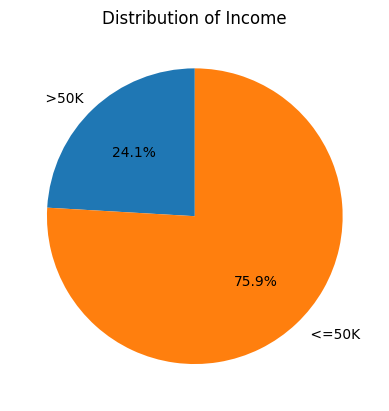

In [332]:
#share of income 
dist_income = salary.groupBy('income').count()
pdf = dist_income.toPandas()
plt.figure()
plt.pie(pdf["count"], labels=pdf["income"], autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Income")
plt.show()

In [333]:
#check what sex earns the most 
salary.groupBy(["sex","income"]).count().orderBy(col("income").desc()).show()

+-------+------+-----+
|    sex|income|count|
+-------+------+-----+
|   Male|  >50K| 6662|
| Female|  >50K| 1179|
|   Male| <=50K|15128|
| Female| <=50K| 9592|
+-------+------+-----+



In [334]:
#Education with the most income
salary.groupBy("education", "income").count().orderBy(col("count").desc()).show()


+-------------+------+-----+
|    education|income|count|
+-------------+------+-----+
|      HS-grad| <=50K| 8826|
| Some-college| <=50K| 5904|
|    Bachelors| <=50K| 3134|
|    Bachelors|  >50K| 2221|
|      HS-grad|  >50K| 1675|
| Some-college|  >50K| 1387|
|         11th| <=50K| 1115|
|    Assoc-voc| <=50K| 1021|
|      Masters|  >50K|  959|
|         10th| <=50K|  871|
|   Assoc-acdm| <=50K|  802|
|      Masters| <=50K|  764|
|      7th-8th| <=50K|  606|
|          9th| <=50K|  487|
|  Prof-school|  >50K|  423|
|         12th| <=50K|  400|
|    Assoc-voc|  >50K|  361|
|      5th-6th| <=50K|  317|
|    Doctorate|  >50K|  306|
|   Assoc-acdm|  >50K|  265|
+-------------+------+-----+
only showing top 20 rows


In [335]:
#Income by age group
salary = salary.withColumn(
    "age_group",
    when(col("age") < 25, "<25")
    .when(col("age") < 45, "25–44")
    .when(col("age") < 65, "45–64")
    .otherwise("65+"),
)

salary.groupBy("age_group", "income").count().orderBy(col("count").desc()).show()

+---------+------+-----+
|age_group|income|count|
+---------+------+-----+
|    25–44| <=50K|12500|
|    45–64| <=50K| 5651|
|      <25| <=50K| 5509|
|    25–44|  >50K| 4130|
|    45–64|  >50K| 3374|
|      65+| <=50K| 1060|
|      65+|  >50K|  276|
|      <25|  >50K|   61|
+---------+------+-----+



In [336]:
# Hours worked per week
salary.groupBy("income").agg(avg("hours-per-week").alias("avg_hours")).show()

+------+------------------+
|income|         avg_hours|
+------+------------------+
|  >50K|45.473026399693914|
| <=50K|38.840210355987054|
+------+------------------+



In [337]:
# Do high earners have capital gains?
salary.groupBy("income").agg(
    round(avg("capital-gain"),2).alias("avg_gain"), round(avg("capital-loss"),2).alias("avg_loss")
).show()


+------+--------+--------+
|income|avg_gain|avg_loss|
+------+--------+--------+
|  >50K| 4006.14|   195.0|
| <=50K|  148.75|   53.14|
+------+--------+--------+



In [338]:
# Marital status vs income
salary.groupBy("marital-status", "income").count().show()

+--------------------+------+-----+
|      marital-status|income|count|
+--------------------+------+-----+
|            Divorced|  >50K|  463|
| Married-spouse-a...| <=50K|  384|
|       Never-married| <=50K|10192|
|             Widowed| <=50K|  908|
|       Never-married|  >50K|  491|
|           Separated| <=50K|  959|
|  Married-civ-spouse|  >50K| 6692|
|            Divorced| <=50K| 3980|
|  Married-civ-spouse| <=50K| 8284|
|           Separated|  >50K|   66|
| Married-spouse-a...|  >50K|   34|
|   Married-AF-spouse| <=50K|   13|
|             Widowed|  >50K|   85|
|   Married-AF-spouse|  >50K|   10|
+--------------------+------+-----+



In [339]:
#Income by Race
salary.groupBy("race", "income").count().orderBy(col('count').desc()).show()


+-------------------+------+-----+
|               race|income|count|
+-------------------+------+-----+
|              White| <=50K|20699|
|              White|  >50K| 7117|
|              Black| <=50K| 2737|
| Asian-Pac-Islander| <=50K|  763|
|              Black|  >50K|  387|
| Asian-Pac-Islander|  >50K|  276|
| Amer-Indian-Eskimo| <=50K|  275|
|              Other| <=50K|  246|
| Amer-Indian-Eskimo|  >50K|   36|
|              Other|  >50K|   25|
+-------------------+------+-----+



In [ ]:
#Country distribution
salary.groupBy("native-country").count().orderBy("count", ascending=False).show(10)


+--------------+-----+
|native-country|count|
+--------------+-----+
| United-States|29753|
|        Mexico|  643|
|   Philippines|  198|
|       Germany|  137|
|        Canada|  121|
|   Puerto-Rico|  114|
|   El-Salvador|  106|
|         India|  100|
|          Cuba|   95|
|       England|   90|
+--------------+-----+
only showing top 10 rows
